### 画像リサイズ

In [7]:
import os
from PIL import Image
import glob

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "labeled/north/"
RESIZED_DIR = DUMP_DIR + "resized/north/"

def resize_image(image_file):
    RESIZE_VAL = 300 # resized pixel
    image = Image.open(image_file)
    image = image.convert("RGB")
    image = image.resize((RESIZE_VAL, RESIZE_VAL))
    return image # return image

def main():
    image_files = glob.glob(DATASET_DIR + "*.jpg")
    for image_file in image_files:
        image = resize_image(image_file)
        image.save(RESIZED_DIR + os.path.basename(image_file)) #save image

if __name__ == "__main__":
    main()


### アノテーションデータ読み込みとデータ作成

In [20]:
import os
from PIL import Image
import glob
import xml.etree.ElementTree as ET
import numpy as np
import random, math

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "annotated/north/"
LABEL_LIST = ['not', 'fourth']

def make_npdataset(xml_elem: ET.ElementTree, file_name: str):
    """from annotate data to numpy data"""
    RESIZE_val = 70, 40 # resize value(width, height)
    # get annotated rect's position
    position = int(xml_elem.find('bndbox/xmin').text), int(xml_elem.find('bndbox/ymin').text), int(xml_elem.find('bndbox/xmax').text), int(xml_elem.find('bndbox/ymax').text)
    
    # get annotated rect's image
    image = Image.open(file_name).convert("RGB")
    image_cropped = image.crop(position)
    image_cropped = image_cropped.resize(RESIZE_val)
    
    # get label index
    label = LABEL_LIST.index(xml_elem.find('name').text)
    
    return np.asarray(image_cropped), label

def make_npdatasets(annotate_files: list):
    """create annotated image's dataset"""
    datasets = []
    OBJECT_QUERY = './/object'
    for annotate_file in annotate_files:
        tree = ET.parse(annotate_file)
        root = tree.getroot()

        image_filename = root.find('path').text # get image's filename
        for xml_elem in root.findall(OBJECT_QUERY):
            datasets.append(make_npdataset(xml_elem, image_filename))
        
    return datasets

def main():
    annotate_files = glob.glob(DATASET_DIR + "*.xml")
    datasets = make_npdatasets(annotate_files)
    random.shuffle(datasets) # shuffle datasets

    # split datasets
    train_size = math.floor(len(datasets) * 0.6)
    val_size = math.floor(len(datasets) * 0.2)
    X_train, y_train = np.array([data[0] for data in datasets[0:train_size]]), np.array([data[1] for data in datasets[0:train_size]])
    X_val, y_val = np.array([data[0] for data in datasets[train_size:train_size + val_size]]), np.array([data[1] for data in datasets[train_size:train_size + val_size]])
    X_test, y_test = np.array([data[0] for data in datasets[train_size + val_size:]]), np.array([data[1] for data in datasets[train_size + val_size:]])
    
    # save dataset array
    xy = (X_train, X_val, X_test, y_train, y_val, y_test)
    np.save(DUMP_DIR + "floor_datasets.npy", xy)

if __name__ == "__main__":
    main()

### ロジスティック回帰による分類

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 8400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8401      
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________
Train on 30 samples, validate on 10 samples
Epoch 1/10
30/30 [==============================] - 0s 13ms/step - loss: 0.8293 - acc: 0.6667 - val_loss: 0.8972 - val_acc: 0.1000
Epoch 2/10
30/30 [==============================] - 0s 451us/step - loss: 0.6779 - acc: 0.6667 - val_loss: 0.3841 - val_acc: 0.9000
Epoch 3/10
30/30 [==============================] - 0s 441us/step - loss: 0.6124 - acc: 0.7000 - val_loss: 0.8687 - val_acc: 0.2000
Epoch 4/10
30/30 [==============================] - 0s 504us/step - loss: 0.8038 - acc: 0.5667 - 

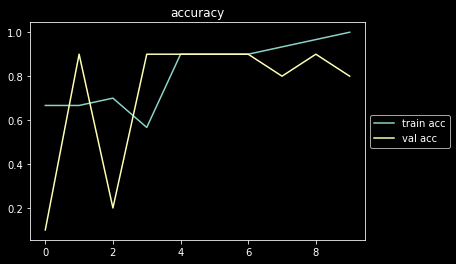

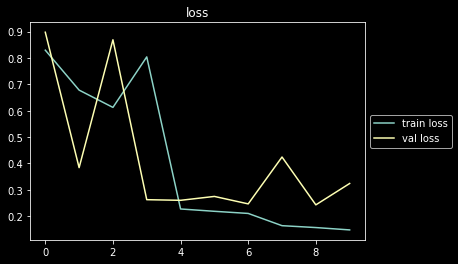

10/10 [==============================] - 0s 100us/step
test loss: 0.39632296562194824
test acc: 0.8999999761581421


In [26]:
from keras import layers, models, backend
import numpy as np
import matplotlib.pyplot as plt
import os

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "annotated/north/"
LABEL_LIST = ['not', 'fourth']
RESIZE_val = 40, 70 # resize value(height, width)

%matplotlib inline

def create_model():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=tuple(list(RESIZE_val) + [3]))) # flatten layer
    model.add(layers.Dense(1, activation="sigmoid")) # logistic regression (output)

    model.summary() # show summary

    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    return model

def train_model(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_train = X_train.astype("float") / 255
    X_val = X_val.astype("float")  / 255
    model_stack = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_val, y_val))
    return model_stack

def show_history(model_stack):
    acc = model_stack.history['acc']
    val_acc = model_stack.history['val_acc']
    loss = model_stack.history['loss']
    val_loss = model_stack.history['val_loss']

    # plot learning curve
    epoch = range(len(acc))
    plt.style.use('dark_background')
    plt.plot(epoch, acc, label="train acc")
    plt.plot(epoch, val_acc, label="val acc")
    plt.title("accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='val loss')
    plt.title('loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def evaluate_data(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_test  = X_test.astype("float")  / 255
    eval_stack = model.evaluate(x=X_test, y=y_test)
    return eval_stack

def main():
    datasets_path = DUMP_DIR + "/floor_datasets.npy"
    model = create_model()

    model_stack = train_model(model, datasets_path) # training model
    show_history(model_stack)

    # evaluate by testsets
    eval_stack = evaluate_data(model, datasets_path)
    print("test loss: " + str(eval_stack[0]))
    print("test acc: " + str(eval_stack[1]))

    # save model
    model_string = model.to_json()
    open(DUMP_DIR + "/floor_model_logistic.json", 'w').write(model_string)

    # save parameter
    model.save_weights(DUMP_DIR + "/floor_params_logistic.hdf5")

if __name__ == "__main__":
    main()


### Sliding Windowによる認識

In [ ]:
import os
from keras import models
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "annotated/north/"
RESIZED_DIR = DUMP_DIR + "resized/north/"
LABEL_LIST = ['not', 'fourth']
WINDOW_val = 70, 40 # resize value(width, height)

# load model
global model
with open(DUMP_DIR + "floor_model_logistic.json", 'r') as f:
    model = models.model_from_json(f.read())
    model.model.load_weights(DUMP_DIR + "floor_params_logistic.hdf5")
    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model

def predict_floor(image_nd: np.ndarray):
    """predict class"""
    return model.predict(image_nd)

def predict_window(image_path: str):
    """predict floor's window"""
    image = Image.open(image_path)
    candidate_positions = []
    # TODO: 画像領域外を含ませない
    # sliding at x
    for x_start in range(0, image.width, image.width // WINDOW_val[0] * 2):
        # sliding at y
        for y_start in range(0, image.height, image.height // WINDOW_val[1] * 2):
            image_cropped = image.crop((x_start, y_start, x_start + WINDOW_val[0], y_start + WINDOW_val[1]))
            result = predict_floor(np.expand_dims(np.asarray(image_cropped), axis=0))
            
            # show image
            if result[0][0] >= 1:
                candidate_positions.append([(x_start, y_start), (x_start + WINDOW_val[0], y_start + WINDOW_val[1])])
                
    return candidate_positions

def show_candidate_rect(image_path: str, positions: list):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    for pos in positions:
        draw.rectangle(pos, outline="red") # draw window's rect
        
    image.show() # show image
    
def main():
    for i, image_path in tqdm(enumerate(glob.iglob(RESIZED_DIR + "*.jpg"))):
        positions = predict_window(image_path)
        # sampling
        if i > 0 and i < 30:
            show_candidate_rect(image_path, positions)
    
if __name__ == "__main__":
    main()

/Users/equanz/.pyenv/versions/3.5.2/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


0it [00:00, ?it/s]

1it [00:00,  1.25it/s]

2it [00:01,  1.41it/s]

3it [00:02,  1.42it/s]

4it [00:02,  1.48it/s]

5it [00:03,  1.57it/s]

6it [00:03,  1.63it/s]

7it [00:04,  1.69it/s]

8it [00:04,  1.76it/s]

9it [00:05,  1.79it/s]

10it [00:05,  1.85it/s]

11it [00:06,  1.87it/s]

12it [00:06,  1.87it/s]

13it [00:07,  1.87it/s]

14it [00:07,  1.89it/s]

15it [00:08,  1.90it/s]

16it [00:08,  1.90it/s]

17it [00:09,  1.92it/s]

18it [00:09,  1.91it/s]

19it [00:10,  1.93it/s]

20it [00:10,  1.95it/s]

21it [00:11,  1.94it/s]

22it [00:12,  1.94it/s]

23it [00:12,  1.94it/s]

24it [00:13,  1.94it/s]

25it [00:13,  1.92it/s]

26it [00:14,  1.93it/s]

27it [00:14,  1.94it/s]

28it [00:15,  1.93it/s]